In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections.abc import Callable

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

from teren.config import ExperimentConfig, Reference
from teren.perturbations import (
    NaiveRandomPerturbation,
    RandomPerturbation,
    RandomActivationPerturbation,
    SAEDecoderDirectionPerturbation,
    run_perturbation
)
from teren.utils import (
    generate_prompt,
    load_pretokenized_dataset,
    set_seed,
    get_device_str,
    set_seed
)

In [3]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=42,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, 1.0),
    n_steps=100,
    mean_batch_size=700,
)

In [4]:
set_seed(cfg.seed)

In [5]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [6]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [7]:
base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [8]:
print(base_prompt)

tensor([[ 338, 5059,  262, 6672,  287, 2669,   13, 9570, 5865, 3205]])


In [9]:
import random

rng = random.Random(cfg.seed)

In [10]:
rng.randint(0,100)

81

In [11]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
sparsity = sparsities[cfg.perturbation_layer].cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


In [12]:
import operator
from teren.perturbations import SAEFeaturePerturbation, TestPerturbation, NaiveRandomPerturbation, SAEActivationPerturbation, SyntheticActivationPerturbation, OtherFeaturePerturbation
from teren.utils import get_random_activation

In [14]:
# Examining SAE features
def get_results_for_prompt(exp_ref, cfg, sae, n_control, thresh, reduce=True):

    feature_acts = sae.encode(exp_ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {feature_idx: feature_acts[feature_idx] for feature_idx in range(feature_acts.shape[0]) if feature_acts[feature_idx] / feature_acts.max() > thresh}

    random_features = {feature_idx: feature_acts[feature_idx] for feature_idx in random.sample(range(feature_acts.shape[0]), 20) if feature_acts[feature_idx] == 0}

    antiparallel_features = {}
    for feature_idx in active_features.keys():
        active_dot_all = torch.einsum("... k, ... j k -> ... j", sae.W_dec[feature_idx], sae.W_dec[[feature for feature in range(sae.W_dec.shape[0]) if feature != feature_idx]]) 
        min_dot = active_dot_all.min(dim=-1)[1].item()
        if min_dot >= feature_idx:
            antiparallel_features[min_dot+1] = feature_acts[min_dot+1]
            print(min_dot+1)
        else:
            antiparallel_features[min_dot] = feature_acts[min_dot]
            print(min_dot)

    sorted_features = sorted(active_features.items(), key=operator.itemgetter(1))

    print(f"Using {len(active_features.keys())} active features: {active_features}")

    base_results = defaultdict(defaultdict)
    target_results = defaultdict(defaultdict)
    control = defaultdict(list)
    sae_control = defaultdict(list)

    for i in tqdm(range(n_control)):

        target = get_random_activation(
            exp_ref.model,
            dataset,
            exp_ref.n_ctx,
            exp_ref.perturbation_layer,
            exp_ref.perturbation_pos,
        )

        print(
            f"Base Recon Error: {(sae.decode(sae.encode(exp_ref.act)) - exp_ref.act).abs().sum()}"
        )
        print(
            f"Target Recon Error: {(sae.decode(sae.encode(target)) - target).abs().sum()}"
        )

        target_f_acts = sae.encode(target)
        target_features = {feature_idx: target_f_acts[feature_idx] for feature_idx in range(target_f_acts.shape[0]) if target_f_acts[feature_idx] / target_f_acts.max() > thresh}
        sorted_features2 = sorted(target_features.items(), key=operator.itemgetter(1))

        for i in range(len(sorted_features)):
            other_feature_perturbation = OtherFeaturePerturbation(exp_ref, target, sorted_features[i][0], dataset, sae)
            base_kl_div = run_perturbation(cfg, exp_ref, other_feature_perturbation, reduce=reduce)
            base_results[sorted_features[i][0]]['kl_div'] = base_kl_div

        for i in range(len(sorted_features2)):
            other_feature_perturbation = OtherFeaturePerturbation(exp_ref, target, sorted_features2[i][0], dataset, sae)
            target_kl_div = run_perturbation(cfg, exp_ref, other_feature_perturbation, reduce=reduce)
            target_results[sorted_features[i][0]]['kl_div'] = target_kl_div
        
        random_activation_perturbation = RandomActivationPerturbation(exp_ref, target, dataset)
        control_kl_div = run_perturbation(cfg, exp_ref, random_activation_perturbation, reduce=reduce)
        control[i].append(control_kl_div)

        sae_activation_perturbation = SAEActivationPerturbation(exp_ref, target, dataset, sae)
        sae_kl_div = run_perturbation(cfg, exp_ref, sae_activation_perturbation, reduce=reduce)
        sae_control[i].append(sae_kl_div)

    return base_results, target_results, control, sae_control


In [15]:
def plot_results(fig, ax, results, control, sae_control):

    i = 0
    for control_kl_div in control.values():
        ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
        ax[i][2].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")

    for sae_kl_div in sae_control.values():
        ax[i][0].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")
        ax[i][2].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")

    for syn_kl_div in syn.values():
        ax[i][0].plot(syn_kl_div, color='green', linewidth=0.5)
        ax[i][1].plot(syn_kl_div, color='green', linewidth=0.5)
        ax[i][2].plot(np.log10(syn_kl_div), color='green', linewidth=0.5)

    #ax.legend(fontsize=8)
    ax[i][0].set_xlabel(f"Distance from base activation at {syn_cfg.read_layer}")
    ax[i][0].set_ylabel("KL divergence to base logits")
    #ax[i][0].set_xlim(0, 361)
    #ax[i][0].set_ylim(-0.1, 20)

    ax[i][1].set_xlabel(f"Distance from base activation at {syn_cfg.read_layer}")
    ax[i][1].set_ylabel("KL divergence to base logits")
    #ax[i][1].set_xlim(0, 361)
    #ax[i][1].set_ylim(-0.1, 20)

    ax[i][2].set_xlabel(f"Distance from base activation at {syn_cfg.read_layer}")
    ax[i][2].set_ylabel("KL divergence to base logits")
    #ax[i][2].set_xlim(0, 180)
    #ax[i][2].set_ylim(-0.01, 2)
    

In [22]:
for i in tqdm(range(1)):
    exp_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    #exp_prompt = our_tokens
    exp_ref = Reference(
        model,
        exp_prompt,
        cfg.perturbation_layer,
        cfg.read_layer,
        cfg.perturbation_pos,
        cfg.n_ctx,
    )
    print(exp_prompt)
    print(f"Prompt: {model.tokenizer.decode(exp_prompt[0])}")
    n_control = 10
    results, controls, sae_controls = get_results_for_prompt(exp_ref, syn_cfg, sae, n_control=n_control, thresh = 0.05, reduce=True)

    if i == 0:     
        all_results = results                               
        all_controls = controls
        all_sae_controls = sae_controls
    else:
        for control_idx, control in controls.items():
            all_controls[n_control*i+control_idx] = control
        
        for control_idx, sae_control in sae_controls.items():
            all_sae_controls[n_control*i+control_idx] = sae_control

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 5290,    11,   356,   389,  1200, 38991,    13,   383,   517,   356]])
Prompt:  worst, we are child abusers. The more we
12757
22864
24189
19226
5807
22864
13033
Using 7 active features: {813: tensor(1.0912), 2065: tensor(3.3712), 3626: tensor(4.1166), 14805: tensor(19.9527), 15017: tensor(4.1741), 17359: tensor(3.3425), 21524: tensor(3.6321)}


Base Recon Error: 132.05010986328125
Target Recon Error: 203.6824188232422


Base Recon Error: 132.05010986328125
Target Recon Error: 141.33380126953125


Base Recon Error: 132.05010986328125
Target Recon Error: 213.25621032714844


Base Recon Error: 132.05010986328125
Target Recon Error: 167.37672424316406


Base Recon Error: 132.05010986328125
Target Recon Error: 155.604736328125


Base Recon Error: 132.05010986328125
Target Recon Error: 122.37299346923828


Base Recon Error: 132.05010986328125
Target Recon Error: 136.30386352539062


Base Recon Error: 132.05010986328125
Target Recon Error: 120.72834014892578


Base Recon Error: 132.05010986328125
Target Recon Error: 130.41131591796875


Base Recon Error: 132.05010986328125
Target Recon Error: 145.00424194335938


100%|██████████| 1/1 [00:26<00:00, 26.55s/it]


In [23]:
print(len(all_syns[0][0]))
print(len(all_controls[0][0]))

100
100


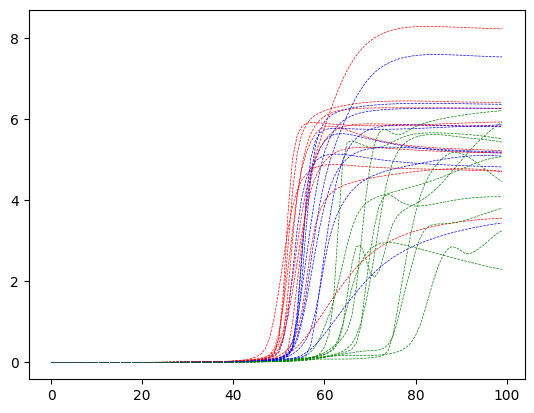

In [24]:
for i in range(n_control):
    plt.plot(all_controls[i][0], color='red', linestyle='--', linewidth=0.5)
    plt.plot(all_sae_controls[i][0], color='blue', linestyle='--', linewidth=0.5)
    plt.plot(all_syns[i][0], color='green', linestyle='--', linewidth=0.5)

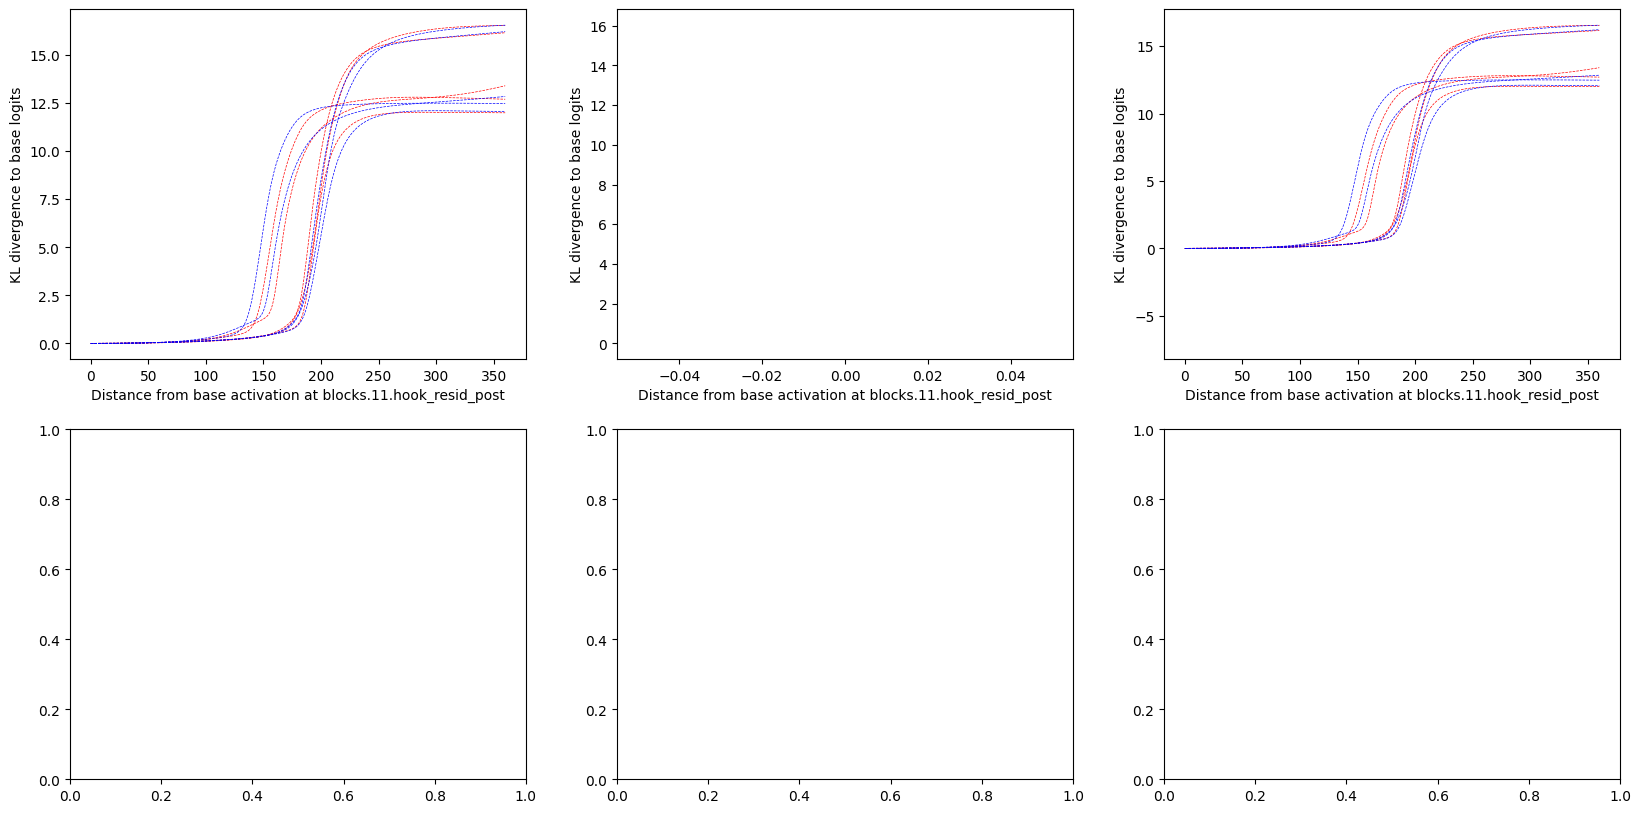

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))

plot_syn_results(fig, ax, all_controls, all_sae_controls, all_syns)
fig.show()